## Importing the DataSet

Firstly, we will import the required data and convert it to usable pandas DataFrames

In [1]:
import pandas as pd


training_set_features = pd.read_csv('training_set_features.csv')
training_set_labels = pd.read_csv('training_set_labels.csv')
training_set = pd.merge(training_set_features, training_set_labels)

testing_set = pd.read_csv('test_set_features.csv')

## Getting the DataSet Ready

Now, we will preprocess the data and handle the missing values

In [2]:
training_set.drop(['employment_industry', 'employment_occupation'], axis = 1, inplace = True)
testing_set.drop(['employment_industry', 'employment_occupation'], axis = 1, inplace = True)

In [3]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit(training_set[['age_group', 'education', 'sex', 'income_poverty', 'marital_status',  'employment_status', 'hhs_geo_region', 'census_msa']])

training_set[['age_group', 'education',  'sex', 'income_poverty', 'marital_status',  'employment_status', 'hhs_geo_region', 'census_msa']] = encoder.transform(training_set[['age_group', 'education',  'sex', 'income_poverty', 'marital_status',  'employment_status', 'hhs_geo_region', 'census_msa']])
testing_set[['age_group', 'education',  'sex', 'income_poverty', 'marital_status',  'employment_status', 'hhs_geo_region', 'census_msa']] = encoder.transform(testing_set[['age_group', 'education',  'sex', 'income_poverty', 'marital_status',  'employment_status', 'hhs_geo_region', 'census_msa']])

In [4]:
# training_set.drop(columns = ['health_insurance'], inplace = True)
training_set.health_insurance=training_set.health_insurance.fillna(0)
testing_set.health_insurance=testing_set.health_insurance.fillna(0)

In [5]:
training_set.income_poverty=training_set.income_poverty.fillna(0)
testing_set.income_poverty=testing_set.income_poverty.fillna(0)

In [6]:
training_set.doctor_recc_seasonal=training_set.doctor_recc_seasonal.fillna(0)
training_set.doctor_recc_xyz=training_set.doctor_recc_xyz.fillna(0)

testing_set.doctor_recc_seasonal=testing_set.doctor_recc_seasonal.fillna(0)
testing_set.doctor_recc_xyz=testing_set.doctor_recc_xyz.fillna(0)

In [7]:
training_set.race = training_set.race.apply(lambda x : 1 if x == 'White' or np.nan else 0)
testing_set.race = testing_set.race.apply(lambda x : 1 if x == 'White' or np.nan else 0)

training_set.rent_or_own = training_set.rent_or_own.apply(lambda x: 1 if x == 'Own' else 0)
testing_set.rent_or_own = testing_set.rent_or_own.apply(lambda x: 1 if x == 'Own' else 0)

In [8]:
training_set.dropna(inplace = True)
testing_set.dropna(inplace = True)

## Training the Model

Now, we will train the model on the training dataset and use it for our predictions. Here we will use a Logistic regression model.

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


X_xyz_train = training_set.drop(['respondent_id', 'xyz_vaccine', 'seasonal_vaccine', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'], axis=1)
X_seas_train = training_set.drop(['respondent_id', 'xyz_vaccine', 'seasonal_vaccine', 'doctor_recc_xyz', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk', 'opinion_xyz_sick_from_vacc'], axis=1)
y_xyz_train = training_set['xyz_vaccine']
y_seas_train = training_set['seasonal_vaccine']



# model_xyz = BernoulliNB()
model_xyz = LogisticRegression(solver='liblinear')
model_xyz.fit(X_xyz_train, y_xyz_train)



# model_seas = BernoulliNB()
model_seas = LogisticRegression(solver='liblinear')
model_seas.fit(X_seas_train, y_seas_train)

LogisticRegression(solver='liblinear')

In [10]:

X_xyz_test = testing_set.drop(['respondent_id', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'], axis=1)
X_seas_test = testing_set.drop(['respondent_id', 'doctor_recc_xyz', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk', 'opinion_xyz_sick_from_vacc'], axis=1)


y_xyz_pred = model_xyz.predict_proba(X_xyz_test)[:, 1]
y_seas_pred = model_seas.predict_proba(X_seas_test)[:, 1]


In [11]:
y_xyz_pred = pd.Series(y_xyz_pred, index = testing_set.respondent_id)
y_seas_pred = pd.Series(y_seas_pred, index = testing_set.respondent_id)

## Plotting the predictions

We will plot our predictions, just to get an idea of them.

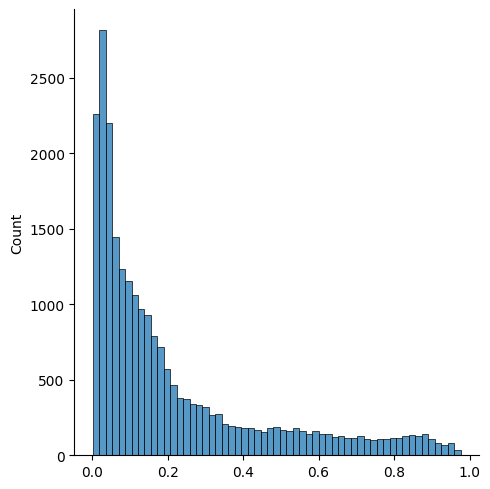

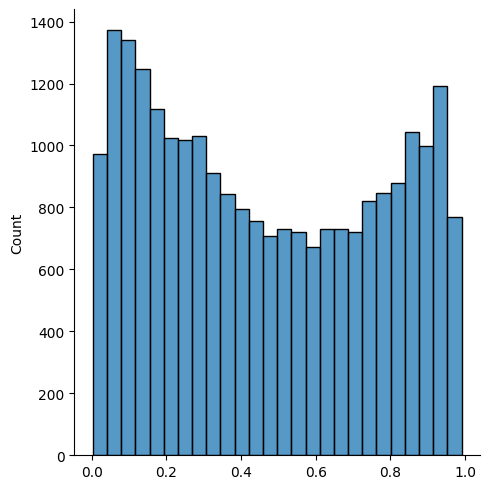

In [12]:
import seaborn as sns
sns.displot(y_xyz_pred)
sns.displot(y_seas_pred)

## Creating the required dataframe

Finally, we will create the required dataframe and get the output in a .csv file

In [13]:
output_df = pd.DataFrame( { "xyz_vaccine" : y_xyz_pred, "seasonal_vaccine" : y_seas_pred } )


In [14]:
l = []
for i in range(26707, 53415):
    l.append(i)

l = pd.Series(l, index = l, name = 'A')
l = pd.DataFrame(l)
l.drop(columns = ['A'], inplace = True)

In [15]:
output_df = pd.concat([l, output_df], axis = 1, join = 'outer')

In [16]:
output_df.xyz_vaccine=output_df.xyz_vaccine.fillna(output_df.xyz_vaccine.median())
output_df.seasonal_vaccine=output_df.seasonal_vaccine.fillna(output_df.seasonal_vaccine.median())
output_df.index.name = 'respondent_id'

In [17]:
output_df.round(4).to_csv('output.csv')